# Exploratory data analysis of Voyager magnetic field time series

In [ ]:
import numpy as np
import pandas as pd
import cdflib
import math as m
import seaborn as sns
import math
from scipy import signal
from matplotlib import pyplot as plt
from statsmodels.graphics import tsaplots
from data_import_funcs import read_cdfs, date_1d_dict, read_asc_ts
from calculate_stats_latest import calc_struct_sdk
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy import fft

## What does a CDF file contents look like?

In [ ]:
cdf_file = cdflib.CDF("data/Voyager/voyager1_48s_mag-vim_20090101_v01.cdf")

In [ ]:
print(cdf_file.globalattsget(expand = False))

{'TITLE': 'VOYAGER1', 'Project': 'VOYAGER1', 'Discipline': ['Space Physics>Interplanetary Studies', 'Solar Physics>Heliospheric Physics'], 'Source_name': 'VOYAGER1> Voyager 1', 'Data_type': '48SEC>48 second Time Resolution', 'Descriptor': 'VIM>Magnetic Field VIM', 'Data_version': '1', 'TEXT': ['The  main science objectives for the VOYAGER interplanetary mission are as   follows: ', '- investigate the structure of the solar wind magnetic fields and plasma in the inner and outer heliosphere; ', '- conduct long term study of heliospheric evolution during different phases of the twenty-two year solar magnetic cycle and the eleven-year solar activity cycle;', '- study the long term solar modulation and determine the elemental and isotopic abundances of galactic cosmic ray particles in the heliosphere;', '- measure  radial gradients, spectra, and nuclear abundances of the anomalous component of cosmic rays  from  acceleration at the solar wind termination shock; ', '- investigate local parti

In [ ]:
#Full data structure
print(cdf_file.cdf_info())

{'CDF': WindowsPath('data/Voyager/voyager1_48s_mag-vim_20090101_v01.cdf'), 'Version': '3.6.1', 'Encoding': 1, 'Majority': 'Column_major', 'rVariables': [], 'zVariables': ['Epoch', 'Epoch_ephem', 'spacecraftID', 'F1', 'BR', 'BT', 'BN', 'dF', 'dBR', 'dBT', 'dBN', 'Radius', 'hg_lat', 'hg_lon', 'hgi_lon'], 'Attributes': [{'TITLE': 'Global'}, {'Project': 'Global'}, {'Discipline': 'Global'}, {'Source_name': 'Global'}, {'Data_type': 'Global'}, {'Descriptor': 'Global'}, {'Data_version': 'Global'}, {'Generated_by': 'Global'}, {'Generation_date': 'Global'}, {'TEXT': 'Global'}, {'MODS': 'Global'}, {'ADID_ref': 'Global'}, {'Logical_file_id': 'Global'}, {'Logical_source': 'Global'}, {'Logical_source_description': 'Global'}, {'PI_name': 'Global'}, {'PI_affiliation': 'Global'}, {'Mission_group': 'Global'}, {'Instrument_type': 'Global'}, {'Time_resolution': 'Global'}, {'Web_site': 'Global'}, {'Acknowledgement': 'Global'}, {'Rules_of_use': 'Global'}, {'LINK_TEXT': 'Global'}, {'LINK_TITLE': 'Global'}, {

In [ ]:
#Variable names - zVariables are variables that can have dimensionalities that are different than those of the rVariables (and each other).
print(cdf_file.cdf_info()['zVariables']) 

['Epoch', 'Epoch_ephem', 'spacecraftID', 'F1', 'BR', 'BT', 'BN', 'dF', 'dBR', 'dBT', 'dBN', 'Radius', 'hg_lat', 'hg_lon', 'hgi_lon']


In [ ]:
#Looking at single variable
print(cdf_file.varinq('F1')) #basic variable information

{'Variable': 'F1', 'Num': 3, 'Var_Type': 'zVariable', 'Data_Type': 21, 'Data_Type_Description': 'CDF_REAL4', 'Num_Elements': 1, 'Num_Dims': 0, 'Dim_Sizes': [], 'Sparse': 'No_sparse', 'Last_Rec': 270112, 'Rec_Vary': True, 'Dim_Vary': [], 'Pad': array([0.], dtype=float32), 'Compress': 0, 'Block_Factor': 0}


In [ ]:
print(cdf_file.varattsget('BR')) #variable attributes

{'FIELDNAM': 'BR in RTN', 'CATDESC': 'BR in RTN (Radial-Tangential-Normal) coordinate system (w/ uncertainty)', 'VALIDMIN': array([-10.], dtype=float32), 'VALIDMAX': array([10.], dtype=float32), 'UNITS': 'nT', 'FORMAT': 'f10.5', 'VAR_TYPE': 'data', 'FILLVAL': array([-1.e+31], dtype=float32), 'DEPEND_0': 'Epoch', 'LABLAXIS': 'Voyager1_BR', 'DISPLAY_TYPE': 'time_series'}


In [ ]:
print(cdf_file.varattsget('Epoch')) #variable attributes

{'FIELDNAM': 'Time', 'CATDESC': 'Time, beginning of interval', 'VALIDMIN': array([6.29876736e+13]), 'VALIDMAX': array([6.3745056e+13]), 'SCALEMIN': array([6.29876736e+13]), 'SCALEMAX': array([6.3745056e+13]), 'UNITS': 'ms', 'FORMAT': 'E14.8', 'MONOTON': 'INCREASE', 'VAR_TYPE': 'support_data', 'DICT_KEY': 'time>epoch', 'FILLVAL': array([-1.e+31]), 'LABLAXIS': 'Epoch', 'AVG_TYPE': ' ', 'DISPLAY_TYPE': ' ', 'VAR_NOTES': ' ', 'SCALETYP': 'LINEAR'}


In [ ]:
print("Missing values for this variable are replaced with:", cdf_file.varattsget('BR')['FILLVAL'])

BR = cdf_file.varget("BR")

print("The structure of this variable is", format(type(BR)))
print("The type of data stored in this variable is", format(BR.dtype))

print(BR)

Missing values for this variable are replaced with: [-1.e+31]
The structure of this variable is <class 'numpy.ndarray'>
The type of data stored in this variable is float32
[ 0.00234  0.00389  0.00027 ... -0.01362 -0.01299 -0.01396]


## Using adapted function from Tulasi to read in multiple CDFs at once

In [ ]:
voyager1_data_raw = read_cdfs(["data/Voyager/voyager1_48s_mag-vim_20090101_v01.cdf", 
            "data/Voyager/voyager1_48s_mag-vim_20100101_v01.cdf", 
            "data/Voyager/voyager1_48s_mag-vim_20110101_v01.cdf",
            "data/Voyager/voyager1_48s_mag-vim_20120101_v01.cdf",
            "data/Voyager/voyager1_48s_mag-vim_20130101_v01.cdf",
            "data/Voyager/voyager1_48s_mag-vim_20140101_v01.cdf",
            "data/Voyager/voyager1_48s_mag-vim_20150101_v01.cdf",
            "data/Voyager/voyager1_48s_mag-vim_20160101_v01.cdf",
            "data/Voyager/voyager1_48s_mag-vim_20170101_v01.cdf",
            "data/Voyager/voyager1_48s_mag-vim_20180101_v01.cdf",            
            "data/Voyager/voyager1_48s_mag-vim_20190101_v01.cdf"],
            ['Epoch', 'F1', 'BR', 'BT', 'BN'])

reading file  data/Voyager/voyager1_48s_mag-vim_20090101_v01.cdf
reading file  data/Voyager/voyager1_48s_mag-vim_20100101_v01.cdf
reading file  data/Voyager/voyager1_48s_mag-vim_20110101_v01.cdf
reading file  data/Voyager/voyager1_48s_mag-vim_20120101_v01.cdf
reading file  data/Voyager/voyager1_48s_mag-vim_20130101_v01.cdf
reading file  data/Voyager/voyager1_48s_mag-vim_20140101_v01.cdf
reading file  data/Voyager/voyager1_48s_mag-vim_20150101_v01.cdf
reading file  data/Voyager/voyager1_48s_mag-vim_20160101_v01.cdf
reading file  data/Voyager/voyager1_48s_mag-vim_20170101_v01.cdf
reading file  data/Voyager/voyager1_48s_mag-vim_20180101_v01.cdf
reading file  data/Voyager/voyager1_48s_mag-vim_20190101_v01.cdf
Done reading data


In [11]:
voyager2_data_raw = read_cdfs(["data/Voyager/voyager2/voyager2_48s_mag_19770820_v02.cdf", 
            "data/Voyager/voyager2/voyager2_48s_mag_19770822_v02.cdf", 
            "data/Voyager/voyager2/voyager2_48s_mag_19770824_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19770829_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19770903_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19770908_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19770913_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19770918_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19770923_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19770928_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19771003_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19771008_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19771013_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19771018_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19771023_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19771028_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19771102_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19771107_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19771112_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19771117_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19771122_v02.cdf",
            "data/Voyager/voyager2/voyager2_48s_mag_19771127_v02.cdf"
            ],
            ['Epoch', 'F1', 'B1', 'B2', 'B3'])

reading file  data/Voyager/voyager2/voyager2_48s_mag_19770820_v02.cdf
reading file  data/Voyager/voyager2/voyager2_48s_mag_19770822_v02.cdf
reading file  data/Voyager/voyager2/voyager2_48s_mag_19770824_v02.cdf
reading file  data/Voyager/voyager2/voyager2_48s_mag_19770829_v02.cdf
reading file  data/Voyager/voyager2/voyager2_48s_mag_19770903_v02.cdf
reading file  data/Voyager/voyager2/voyager2_48s_mag_19770908_v02.cdf
reading file  data/Voyager/voyager2/voyager2_48s_mag_19770913_v02.cdf
reading file  data/Voyager/voyager2/voyager2_48s_mag_19770918_v02.cdf
reading file  data/Voyager/voyager2/voyager2_48s_mag_19770923_v02.cdf
reading file  data/Voyager/voyager2/voyager2_48s_mag_19770928_v02.cdf
reading file  data/Voyager/voyager2/voyager2_48s_mag_19771003_v02.cdf
reading file  data/Voyager/voyager2/voyager2_48s_mag_19771008_v02.cdf
reading file  data/Voyager/voyager2/voyager2_48s_mag_19771013_v02.cdf
reading file  data/Voyager/voyager2/voyager2_48s_mag_19771018_v02.cdf
reading file  data/V

In [12]:
voyager1_data = date_1d_dict(voyager1_data_raw, '48S') #Resampling with freq means we do not get lines drawn between missing data points on line plots, however it does require some averaging which puts the time points slightly off
voyager2_data = date_1d_dict(voyager2_data_raw, '48S')
#voyager1_data['mag_calculated'] = (voyager1_data['BR']**2 + voyager1_data['BT']**2 + voyager1_data['BN']**2)**(1/2)
#voyager1_data[voyager1_data.mag_calculated < 0.03] = np.nan
#print(voyager1_data.mag_calculated.min())
len(voyager1_data)
len(voyager2_data)

Here is a snippet of the raw data (before re-sampling according to freq)
                              F1       BR       BT       BN
Time                                                       
2009-01-01 04:10:26.688  0.03748  0.00234 -0.03724  0.00140
2009-01-01 04:11:15.071  0.03568  0.00389 -0.03502 -0.00349
2009-01-01 04:12:02.592  0.03636  0.00027 -0.03588 -0.00027
2009-01-01 04:12:50.975  0.03251 -0.00370 -0.03189 -0.00236
2009-01-01 04:13:39.360  0.03219 -0.00072 -0.03181 -0.00232
Here is a snippet of the raw data (before re-sampling according to freq)
                            F1     B1     B2     B3
Time                                               
1977-08-20 15:57:30.323    0.0    0.0    0.0    0.0
1977-08-20 15:58:18.323    0.0    0.0    0.0    0.0
1977-08-20 15:59:06.323  999.0  999.0  999.0  999.0
1977-08-20 15:59:54.323    0.0    0.0    0.0    0.0
1977-08-20 16:00:42.323    0.0    0.0    0.0    0.0


185997

In [13]:
def convert_angle(x):
    if x < 0: x+=360
    return(x)

voyager1_data['lambda'] = voyager1_data['BT'].div(voyager1_data['BR']).apply(m.atan).apply(m.degrees).apply(convert_angle)
voyager1_data['delta'] = voyager1_data['BN'].div(voyager1_data['F1']).apply(m.asin).apply(m.degrees)

In [14]:
voyager2_data = date_1d_dict(voyager2_data_raw, '48S', 1) #Resampling with freq means we do not get lines drawn between missing data points on line plots, however it does require some averaging which puts the time points slightly off

KeyError: 'BT'

In [ ]:
voyager2_data[6939211:].dropna()

,F1,BT,BR,BN,lambda,delta
Time,,,,,,
2019-08-23 00:42:24,0.56969,-0.52467,-0.02453,0.22057,87.323188,22.778864
2019-08-23 00:43:12,0.56441,-0.52015,-0.02356,0.21775,87.406582,22.693484
2019-08-23 00:44:00,0.56577,-0.52598,-0.01809,0.20761,88.030206,21.527715
2019-08-23 00:44:48,0.56210,-0.52164,-0.01427,0.20888,88.433006,21.814728
2019-08-23 00:45:36,0.55799,-0.52109,-0.01228,0.19909,88.650018,20.903711
...,...,...,...,...,...,...
2019-08-28 03:05:36,0.53125,-0.48849,-0.00510,0.20866,89.401834,23.127078
2019-08-28 03:06:24,0.53516,-0.49400,-0.00958,0.20548,88.889019,22.579186
2019-08-28 03:07:12,0.53928,-0.49501,0.00161,0.21385,270.186352,23.362508


In [ ]:
voyager2_data.isnull().sum().div((len(voyager2_data))) # % missing 

F1    0.341355
B1    0.341355
B2    0.341355
B3    0.341355
dtype: float64

In [ ]:
#Proportion of missing data
print(voyager1_data['F1'].isna().sum()/len(voyager1_data['F1']))

#IF ANY MISSING, USE THE FOLLOWING CODE TO CHOOSE SUBSET
#Get longest non-missing period, investigate properties (not needed when averaging data)
a = voyager1_data['F1'].values  # Extract out relevant column from dataframe as array
m = np.concatenate(( [True], np.isnan(a), [True] ))  # Mask
ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits
start,stop = ss[(ss[:,1] - ss[:,0]).argmax()]  # Get max interval, interval limits
print(voyager1_data['F1'][[start]])
print(voyager1_data['F1'][[stop-1]])

0.7012171879036938
Time
2017-07-29 20:56:48    0.45713
Freq: 48S, Name: F1, dtype: float64
Time
2017-07-30 16:08:00    0.45054
Freq: 48S, Name: F1, dtype: float64


In [ ]:
#Proportion of missing data
print(voyager2_data['F1'].isna().sum()/len(voyager2_data['F1']))

#IF ANY MISSING, USE THE FOLLOWING CODE TO CHOOSE SUBSET
#Get longest non-missing period, investigate properties (not needed when averaging data)
a = voyager2_data['F1'].values  # Extract out relevant column from dataframe as array
m = np.concatenate(( [True], np.isnan(a), [True] ))  # Mask
ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits
start,stop = ss[(ss[:,1] - ss[:,0]).argmax()]  # Get max interval, interval limits
print(voyager2_data['F1'][[start]])
print(voyager2_data['F1'][[stop-1]])

0.34135496809088317
Time
1977-09-03 23:41:36    6.748288
Freq: 48S, Name: F1, dtype: float64
Time
1977-09-04 22:52:48    999.0
Freq: 48S, Name: F1, dtype: float64


In [ ]:
clean = voyager2_data['2017-07-29 20:56:48':'2017-07-30 16:08:00']
len(clean)
#clean.head()

1440

In [31]:
dirty_subset = voyager1_data[50000:55000]
#Proportion of missing data
print(dirty_subset['BT'].isna().sum()/len(dirty_subset['BT']))

np.save(file = 'gappy_voyager.npy', arr = dirty_subset)
len(dirty_subset)
print(dirty_subset.head())
print(dirty_subset.tail())

0.7462
                          F1       BR       BT       BN     lambda     delta
Time                                                                        
2009-01-28 22:50:24  0.12494  0.00773  0.12313 -0.01928  86.407732 -8.877017
2009-01-28 22:51:12  0.12275  0.02039  0.11985 -0.01629  80.344753 -7.626149
2009-01-28 22:52:00  0.12195  0.01255  0.12039 -0.01278  84.048723 -6.015474
2009-01-28 22:52:48  0.12062  0.01949  0.11835 -0.01150  80.648407 -5.470932
2009-01-28 22:53:36  0.11785  0.02330  0.11501 -0.00618  78.547391 -3.005943
                     F1  BR  BT  BN  lambda  delta
Time                                              
2009-01-31 17:26:24 NaN NaN NaN NaN     NaN    NaN
2009-01-31 17:27:12 NaN NaN NaN NaN     NaN    NaN
2009-01-31 17:28:00 NaN NaN NaN NaN     NaN    NaN
2009-01-31 17:28:48 NaN NaN NaN NaN     NaN    NaN
2009-01-31 17:29:36 NaN NaN NaN NaN     NaN    NaN


c:\Users\spann\Documents\Summer research\data_files\calculate_stats_latest.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdk['2^2']=sdk['2']**2


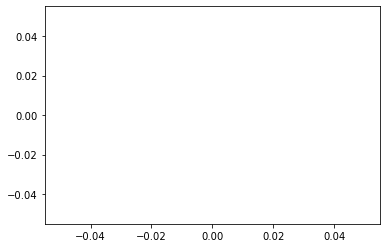

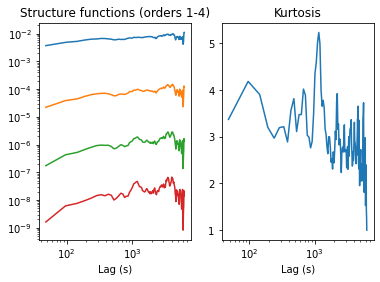

In [25]:
plt.plot()
calc_struct_sdk(dirty_subset['BT'],1/48,True)
output = calc_struct_sdk(dirty_subset['BT'],1/48,False)

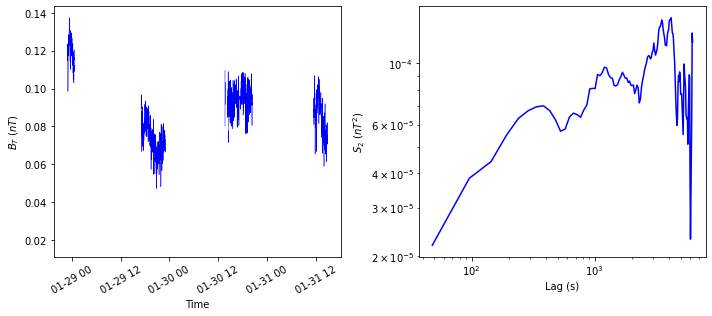

In [47]:
fig, axs = plt.subplots(1,2, figsize= (10,4.5))
axs[0].plot(dirty_subset['BT'], color = 'blue', lw=0.5)
axs[0].set(xlabel = 'Time', ylabel = "nT")
#fig.autofmt_xdate()
axs[0].tick_params(axis='x', labelrotation=30)
axs[1].plot(output[2], color = 'blue')
axs[1].semilogx()
axs[1].semilogy()
axs[1].set(xlabel = 'Lag (s)')
axs[0].set(ylabel = '$B_T$ ($nT$)')
axs[1].set(ylabel = '$S_2$ ($nT^2$)')
fig.tight_layout()
#plt.savefig("voyager_gapped_int_sf.png")

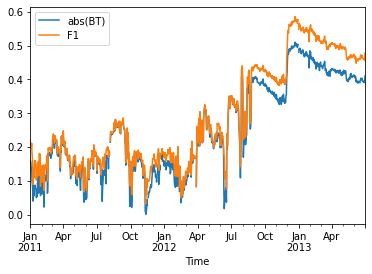

In [46]:
#Reproducing Burlaga et al. (2014) Fig. 1
burlaga_subset = voyager1_data['2011':'2013-06'].resample('D').mean()
burlaga_subset['abs(BT)'] = burlaga_subset['BT'].apply(abs)
burlaga_subset[['abs(BT)', 'F1']].plot()
plt.show()

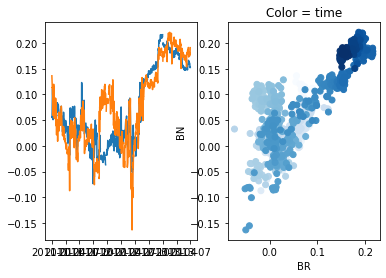

In [42]:
#See how correlation between the two components changes with time
fig, axs = plt.subplots(1,2)
axs[0].plot(burlaga_subset[['BR', 'BN']])
axs[1].scatter(burlaga_subset['BR'], burlaga_subset['BN'], c = burlaga_subset.index, cmap = plt.cm.Blues)
axs[1].set(xlabel = 'BR', ylabel = 'BN', title = "Color = time")
plt.show()

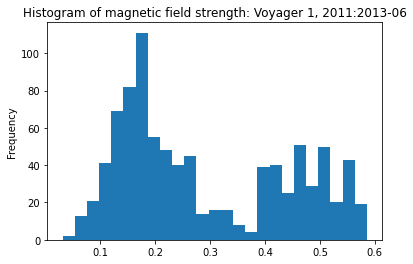

In [43]:
#Reproducing Burlaga et al. (2014) Fig. 2
burlaga_subset['F1'].plot(kind='hist', bins=25, title = 'Histogram of magnetic field strength: Voyager 1, 2011:2013-06') 
#Clear bimodal distribution represents Heliosheath (smaller values) and Interstellar magnetic field (larger values)
plt.show()


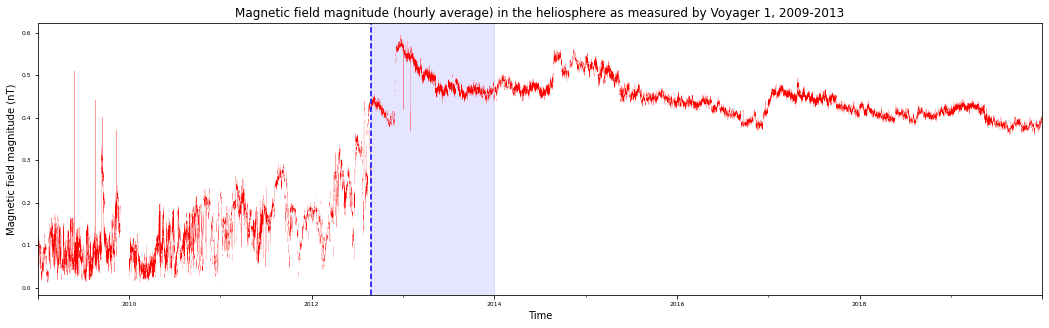

In [47]:
#Raw data for B with line for heliopause (takes a long time to run)
temp_plot = voyager1_data['F1'].resample('H').mean().plot(color = "red", figsize=(18, 5), lw=0.2, fontsize=6, title = 'Magnetic field magnitude (hourly average) in the heliosphere as measured by Voyager 1, 2009-2013')
temp_plot.set_ylabel('Magnetic field magnitude (nT)')
#Adding a vertical line (e.g. to emphasise a heliospheric boundary)
temp_plot.axvline('2012-08-25', color='blue', linestyle='--')
#Adding a shaded region (e.g. to highlight a heliospheric region)
temp_plot.axvspan('2012-08-25', '2013-12-31', color='blue' , alpha=0.1)

## Removing outliers

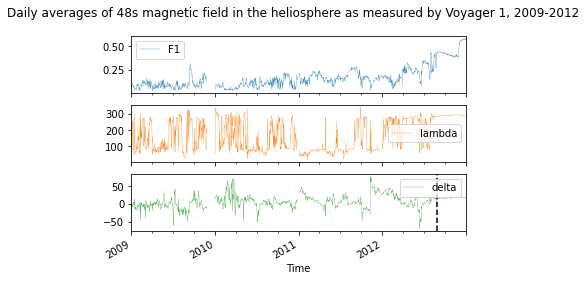

In [24]:
#Daily smoothed plots of each variable - should replicate Fraternale et al. (2019), Fig. 1
smoothed_data1 = voyager1_data[['F1', 'lambda', 'delta']]['2009':'2012'].resample('D').mean()
smoothed_data1.plot(subplots = True, title = 'Daily averages of 48s magnetic field in the heliosphere as measured by Voyager 1, 2009-2012', lw = 0.3)
plt.axvline('2012-08-25', color='black', linestyle='--')
plt.show()

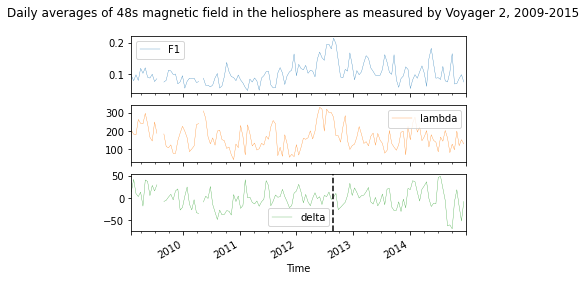

In [46]:
#Daily smoothed plots of each variable - should replicate Fraternale et al. (2019), Fig. 1
smoothed_data2 = voyager2_data[['F1', 'lambda', 'delta']]['2009':'2014'].resample('15D').mean()
smoothed_data2.plot(subplots = True, title = 'Daily averages of 48s magnetic field in the heliosphere as measured by Voyager 2, 2009-2015', lw = 0.3)
plt.axvline('2012-08-25', color='black', linestyle='--')
plt.show()

In [47]:
SHS1_V2 = voyager2_data['2009-07-01':'2009-07-3']
print(SHS1_V2) #Some missing data

clean_short = voyager1_data['2009-05-10 12:38':'2009-05-10 23:59']['F1'].dropna()
print(clean_short)

                          F1       BT       BR       BN      lambda      delta
Time                                                                          
2009-07-01 00:00:00      NaN      NaN      NaN      NaN         NaN        NaN
2009-07-01 00:00:48      NaN      NaN      NaN      NaN         NaN        NaN
2009-07-01 00:01:36      NaN      NaN      NaN      NaN         NaN        NaN
2009-07-01 00:02:24      NaN      NaN      NaN      NaN         NaN        NaN
2009-07-01 00:03:12      NaN      NaN      NaN      NaN         NaN        NaN
...                      ...      ...      ...      ...         ...        ...
2009-07-03 23:56:00  0.07554 -0.05825  0.04721 -0.00332  309.023803  -2.518974
2009-07-03 23:56:48  0.06801 -0.05055  0.04212 -0.01717  309.802226 -14.623301
2009-07-03 23:57:36  0.06757 -0.04179  0.04965 -0.01630  319.912953 -13.959225
2009-07-03 23:58:24  0.06124 -0.03953  0.03767 -0.01169  313.619825 -11.004630
2009-07-03 23:59:12  0.07379 -0.05490  0.04436 -0.02

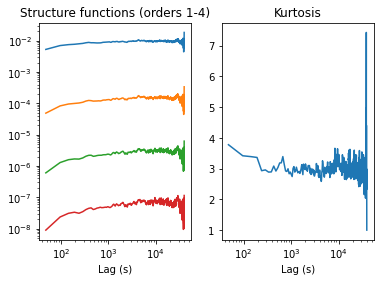

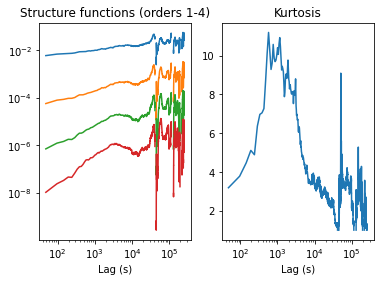

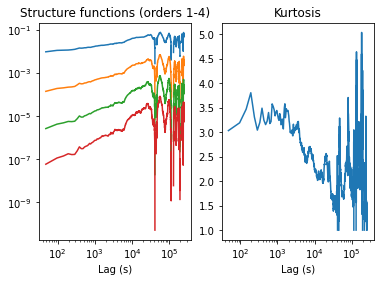

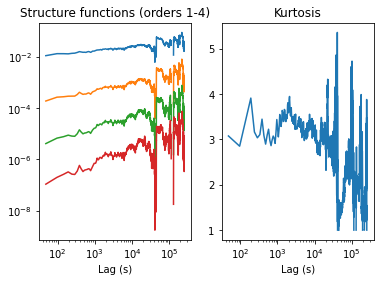

In [69]:
calc_struct_sdk(clean_short, 1/48) #Period of 12 hours (no missing data)
calc_struct_sdk(SHS1_V2['BR'], 1/48) #Period of three days, including missing data
calc_struct_sdk(SHS1_V2['BT'], 1/48) #Period of three days, including missing data
calc_struct_sdk(SHS1_V2['BN'], 1/48) #Period of three days, including missing data

## Comparing with Tulasi's function

In [50]:
#Tulasi's kurtosis function

def kurtosis(series, ptlag):
    """
    Routine to perform the Kurtosis on a series at a certain lag
    Input:
	series: the series to take the kurtosis of
	ptlag: the array of lags that represents the number of points to shift the series by
    Output:
	k: the kurtosis of the series
	ptlag: same array as input
    """
    k = []
    ptlag = np.asarray(ptlag).astype(int)
    series = series.copy()
    for i in ptlag:
        temp = (series.shift(-i) - series).copy()
        if (temp.pow(2).mean())**2 == 0 or (temp.pow(4).mean()) == 0:
            coeff = np.NaN
        else:
            coeff = temp.pow(4).mean()/(temp.pow(2).mean()**2)
        k += [coeff]
    k = pd.Series(k)

    return k, ptlag


[]

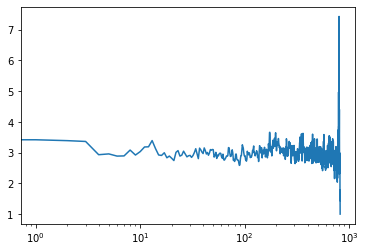

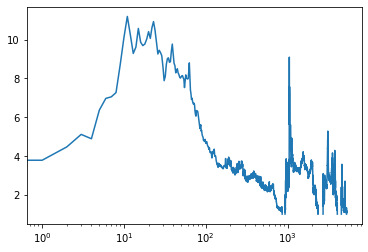

In [68]:
lags_1 = np.arange(1, len(clean_short))
lags_2 = np.arange(1, len(SHS1_V2))

kurtosis_output, array = kurtosis(clean_short, lags_1)
fig, axs = plt.subplots(1)
axs.plot(kurtosis_output)
axs.semilogx()

kurtosis_output, array = kurtosis(SHS1_V2['BR'], lags_2)
fig, axs = plt.subplots(1)
axs.plot(kurtosis_output)
axs.semilogx()

## Testing on simulated data

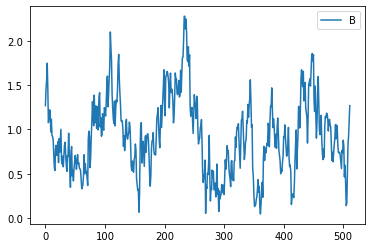

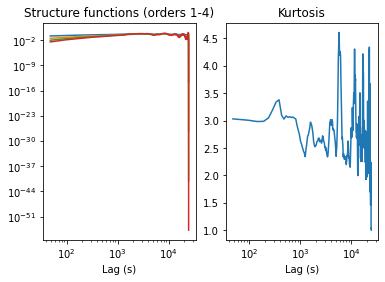

[]

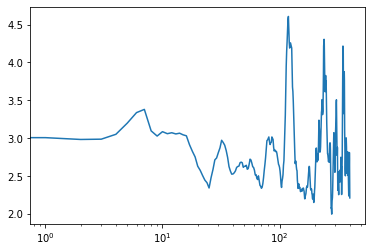

In [73]:
df = pd.read_csv('Bmag_sim')
df.head()
df.plot()
calc_struct_sdk(df['B'], 1/48)

lags = np.arange(1, 400)
kurtosis_output, array = kurtosis(df['B'], lags)
fig, axs = plt.subplots(1)
axs.plot(kurtosis_output)
axs.semilogx()

Looking at data gaps and performing v simple interpolation

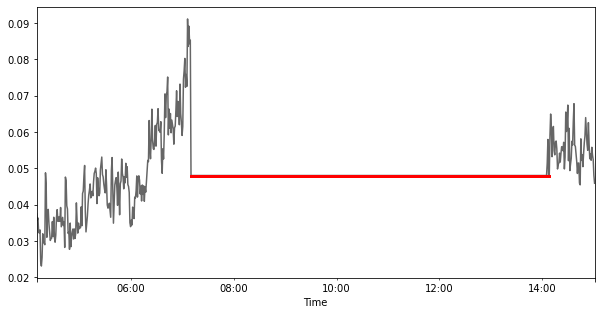

In [19]:
subset = voyager1_data['F1']['2009-01-01 04:00':'2009-01-01 15:00']
missing_values = subset.isna()
#vygr_interp = subset.interpolate('zero')
#Could also replace with median of dataset
vygr_interp = subset.fillna(np.nanmedian(subset))
fig, ax = plt.subplots(figsize = (10, 5))
vygr_interp.plot(color = 'k', alpha = .6, ax = ax, legend = False)
vygr_interp[missing_values].plot(ax = ax, color = 'r', lw = 3, legend = False)
plt.show()

## Spectral analysis

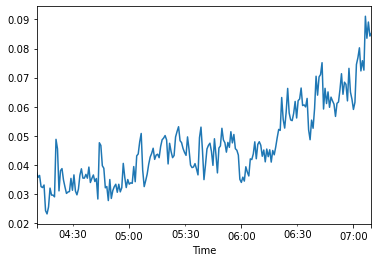

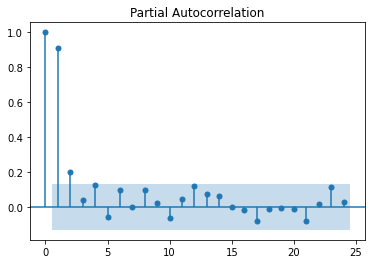

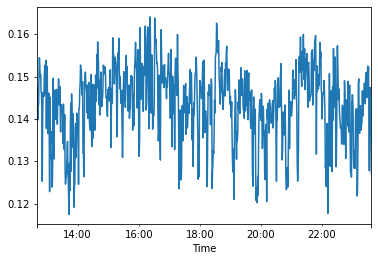

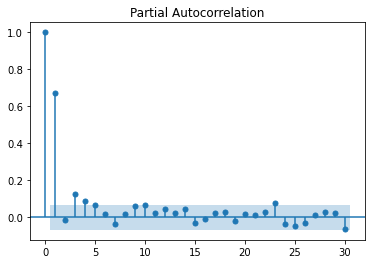

In [20]:
#Extracting a couple of clean subsets and calculating (partial) autocorrelation

subset = voyager1_data['F1']['2009-01-01 4:10:24':'2009-01-01 07:09']
subset.isnull().sum()
subset.plot()
plt.show()

tsaplots.plot_pacf(subset)
plt.show()

subset2 = voyager1_data['2009-05-10 12:38':'2009-05-10 23:59']['F1'].dropna()
subset2.plot()

tsaplots.plot_pacf(subset2)
plt.show()

In [21]:
k = np.arange(1,251)/10000 #wavenumber for each mode
alpha = -5/3 #power law for power spectrum

A_1 = (k**(-5/3))/1000000 #amplitudes
A_2 = (k**(-5/6))/1000 #amplitudes

plt.plot(k, A)
plt.semilogx()
plt.semilogy()
plt.show()

NameError: name 'A' is not defined

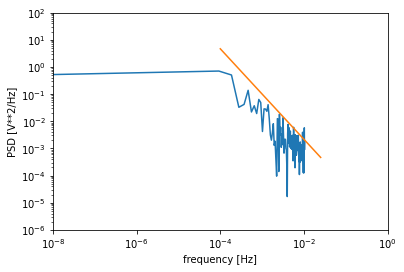

In [63]:
#Calculating power density spectrum (I think)
#1/48s = 0.0208Hz is the maximum frequency

f, Pxx_den = signal.periodogram(subset, 0.0208) #See also: signal.welch
plt.semilogy(f, Pxx_den)
plt.plot(k, A_1)
plt.semilogx()
plt.xlim([1e-8, 1e0])
plt.ylim([1e-6, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

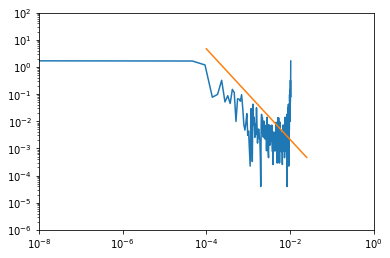

In [66]:
#Power spectrum (here) = square of absolute value of discrete Fourier transform
sampling_rate = 1/48

fourier_transform = np.fft.fft(subset) #Compute Fourier transform of data
magnitudes = abs(fourier_transform)
power_spectrum = np.square(magnitudes)

frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))

plt.plot(frequency, power_spectrum)
plt.plot(k, A_1)
plt.semilogx()
plt.semilogy()
plt.xlim([1e-8, 1e0])
plt.ylim([1e-6, 1e2])
plt.show()

# Importing daily data on proton temperature and density from ASC file


In [24]:
data = read_asc_ts("voyager/voyager1_daily.asc", 
            [0, 1, 2, 14, 15],
            {'Year': 999.999, 'Day': 999.999, 'Hour':999.999, "Proton density": 99.99999, "Proton temperature": 9999999}, 'D')

The unique hours in this dataset are: [0]


In [25]:
data.head()

,Proton density,Proton temperature
Time,,
1977-01-01,NaN,NaN
1977-01-02,NaN,NaN
1977-01-03,NaN,NaN
1977-01-04,NaN,NaN
1977-01-05,NaN,NaN


In [26]:
print(data[data['Proton density'].notnull()])
print(data[data['Proton temperature'].notnull()])

            Proton density  Proton temperature
Time                                          
1977-09-07         6.50961             56486.0
1977-09-08        11.77037             41582.0
1977-09-09         8.06071             79608.0
1977-09-10         6.19061             92300.0
1977-09-11         8.68447            100807.0
...                    ...                 ...
1980-11-21         0.13605             14242.0
1980-11-22         0.22841             11759.0
1980-12-22         0.00254              4168.0
1980-12-30         0.00334             27008.0
1980-12-31         0.00440             58516.0

[1116 rows x 2 columns]
            Proton density  Proton temperature
Time                                          
1977-09-07         6.50961             56486.0
1977-09-08        11.77037             41582.0
1977-09-09         8.06071             79608.0
1977-09-10         6.19061             92300.0
1977-09-11         8.68447            100807.0
...                    ...         

<AxesSubplot:xlabel='Time'>

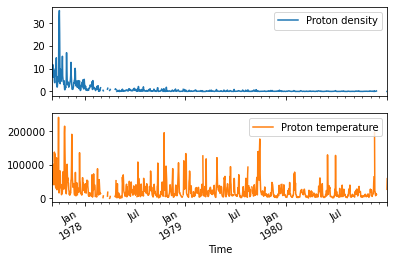

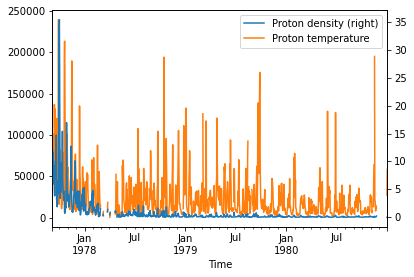

In [27]:
#Revising the range of the data
data = data['1977-09-07':'1980-12-31']
data.plot(subplots = True)
data.plot(secondary_y = 'Proton density')

In [28]:
data.isnull().sum().div(len(data)) # % missing data

Proton density        0.079208
Proton temperature    0.079208
dtype: float64

In [29]:
data.describe()

,Proton density,Proton temperature
count,1116.000000,1116.000000
mean,0.842078,24275.247312
std,2.501148,27757.026962
min,0.002080,410.000000
25%,0.066733,7687.250000
50%,0.158105,15233.500000
75%,0.462703,30067.250000
max,35.379840,239761.000000


In [30]:
raw_corr = data['Proton density'].corr(data['Proton temperature'])
pct_chg_corr = data['Proton density'].pct_change().corr(data['Proton temperature'].pct_change())
print("Correlation of proton density and proton temperature %4.2f" %(raw_corr))
print("Correlation of proton density and proton temperature percent changes %4.2f" %(pct_chg_corr))

Correlation of proton density and proton temperature 0.22
Correlation of proton density and proton temperature percent changes 0.32


<AxesSubplot:ylabel='Density'>

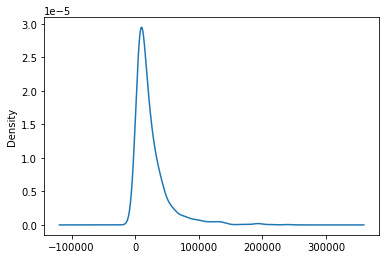

In [31]:
data['Proton temperature'].plot(kind = "density")

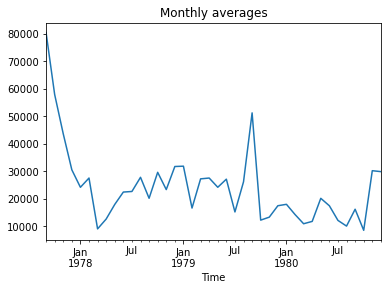

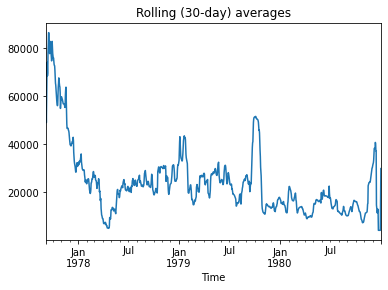

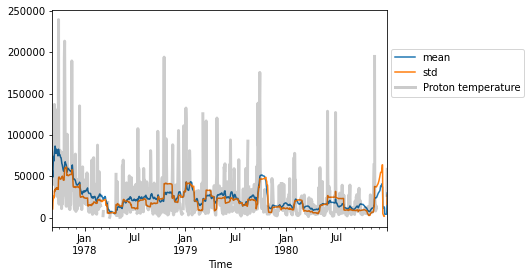

In [40]:
temp = data['Proton temperature']

monthly = temp.resample('M').mean()
monthly.plot(title = "Monthly averages")
plt.show()
monthly = temp.rolling(window='30D').mean()
monthly.plot(title = "Rolling (30-day) averages")

rolling_stats = temp.rolling(window = '30D').agg(['mean', 'std'])
# stats = temp.join(rolling_stats)
# stats[['Proton temperature', 'max', 'std']].plot(subplots = True, title = 'Daily voyager temp with rolling (30-day) mean and standard deviation')

ax = rolling_stats.plot()
temp.plot(ax=ax, color='k', alpha=.2, lw=3)
ax.legend(loc=(1.01, .6))
plt.show()

## Calculating lag

            Proton density  Proton temperature
Time                                          
1977-09-07         6.50961             56486.0
1977-09-08        11.77037             41582.0
1977-09-09         8.06071             79608.0
1977-09-10         6.19061             92300.0
1977-09-11         8.68447            100807.0
            Proton density  Proton temperature
Time                                          
1977-09-08         5.26076            -14904.0
1977-09-09        -3.70966             38026.0
1977-09-10        -1.87010             12692.0
1977-09-11         2.49386              8507.0
1977-09-12        -2.46050            -60513.0


array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>],
      dtype=object)

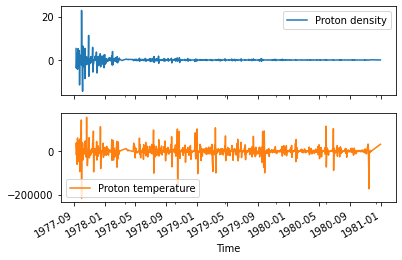

In [79]:
lag_1 = data.diff().dropna()
print(data.head())
print(lag_1.head())
lag_1[['Proton density', 'Proton temperature']].plot(subplots = True)

<AxesSubplot:xlabel='Proton temperature', ylabel='Density'>

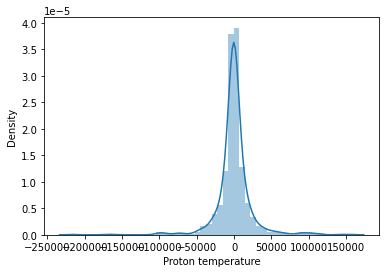

In [82]:
sns.distplot(lag_1['Proton temperature'])

## Calculation autocorrelation

In [83]:
autocorrelation = data['Proton temperature'].autocorr()
print("The autocorrelation of proton temperature is %4.2f" %(autocorrelation))

autocorrelation = data['Proton density'].autocorr()
print("The autocorrelation of proton density is %4.2f" %(autocorrelation))

The autocorrelation of proton temperature is 0.62
The autocorrelation of proton density is 0.86


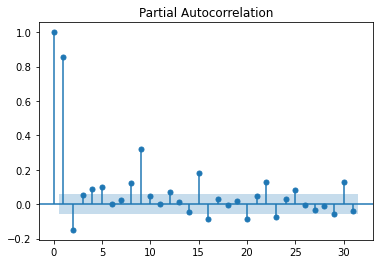

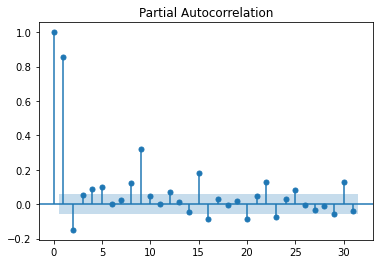

In [88]:
plot_pacf(data['Proton density'].dropna()) #Don't know why it creates